# GLM

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.experience import charters
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

## Simple Model

A logistic regression is of the form:

$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}
$$

The odds ratio determines the increase with a value change in the variable defined as:

$$
odds = \frac{p}{1-p}
$$

If wanting to adjust a value using a base probabilty the probability first needs to be transformed to odds and then adjusted and transformed back

$$
\displaylines{
\text{base\_odds} = \frac{p}{1-p} \\
\text{adj\_odds} = \text{base\_odds} \cdot \text{new\_odds} \\
\text{new\_prob} = \frac{\text{adj\_odds}}{1 + \text{adj\_odds}}
}
$$


Creating a test dataset to show how the parameters of a glm are used.

In [79]:
data = {
    "sex": [0, 0, 0, 1, 1, 1],
    "face": [0, 1, 2, 0, 1, 2],
    "rate": [0.09000, 0.04500, 0.02250, 0.10000, 0.05000, 0.02500],
}
df = pd.DataFrame(data)

preprocess_dict = preprocessors.preprocess_data(
    df,
    feature_dict={
        "target": ["rate"],
        "weight": [],
        "passthrough": ["sex", "face"],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

# model the data
GLM = models.GLM()
GLM.fit(X, y)

 2024-05-08 23:26:51 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2024-05-08 23:26:51 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-05-08 23:26:51 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['face', 'sex', 'constant'] 


In [81]:
print(GLM.model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   rate   No. Observations:                    6
Model:                            GLM   Df Residuals:                        3
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:               -0.92828
Date:                Wed, 08 May 2024   Deviance:                   1.0803e-05
Time:                        23:26:54   Pearson chi2:                 1.08e-05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01679
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
face          -0.7341      2.450     -0.300      0.7

In [82]:
GLM.model.predict(X)

0    0.089950
1    0.045289
2    0.022260
3    0.099678
4    0.050455
5    0.024868
dtype: float64

In [120]:
odds = GLM.get_odds()
params = GLM.model.params

 2024-05-08 23:43:36 | morai.forecast.models | INFO     | generating odds ratio from model 


The logistic regression can be calculated using the parameters or by using the odds ratios to adjust the probablity

In [119]:
sex = 0
face = 2

probability = 1 / (
    1 + np.exp(-(params["constant"] + params["sex"] * sex + params["face"] * face))
)
print(f"probability: {probability}")

base = 1 / (1 + np.exp(-(params["constant"])))
base_odd = base / (1 - base)
sex_odd = odds["sex"] ** sex if sex > 0 else 1
face_odd = odds["face"] ** face if face > 0 else 1
adj_odd = base_odd * sex_odd * face_odd

new_prob = adj_odd / (1 + adj_odd)
print(f"new_prob: {new_prob}")

probability: 0.022260374171510687
new_prob: 0.022260374171510687


## Historical Improvement

This is a simple example that is comparing between 2 scenarios.
1. **rate:** historical experience *is not* adjusted for mortality improvment
2. **rate_adj:** historical *is* adjusted for mortality improvement

In [18]:
model_data = pd.read_csv("tests/files/forecast/simple_data.csv")

In [19]:
model_data

,year,gender,rate,rate_adj
0,2010,1,0.10,0.10
1,2011,1,0.09,0.10
2,2012,1,0.08,0.10
3,2013,1,0.07,0.10
4,2014,1,0.06,0.10
5,2015,1,0.05,0.10
6,2016,1,0.04,0.10
7,2017,1,0.03,0.10
8,2018,1,0.02,0.10
9,2019,1,0.01,0.10


In [20]:
forecast_list = [
    {
        "rate": "pred_rate",
        "feature_dict": {
            "target": ["rate"],
            "weight": [],
            "passthrough": ["year", "gender"],
        },
    },
    {
        "rate": "pred_rate_adj",
        "feature_dict": {
            "target": ["rate_adj"],
            "weight": [],
            "passthrough": ["gender"],
        },
    },
    {
        "rate": "pred_rate_gender",
        "feature_dict": {
            "target": ["rate"],
            "weight": [],
            "passthrough": ["gender"],
        },
    },
]

In [21]:
for forecast in forecast_list:
    feature_dict = forecast["feature_dict"]
    rate = forecast["rate"]
    preprocess_dict = preprocessors.preprocess_data(
        model_data, feature_dict=feature_dict, standardize=False, add_constant=True
    )

    X = preprocess_dict["X"]
    y = preprocess_dict["y"]
    weights = preprocess_dict["weights"]
    mapping = preprocess_dict["mapping"]

    GLM = models.GLM()
    GLM.fit(X, y, weights)

    # print(GLM.model.summary())

    predictions = GLM.model.predict(X)
    model_data[rate] = predictions

# charters.pdp(model=GLM.model, df=model_data, x_axis="gender", mapping=mapping)

 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['year', 'gender'] 
 2024-04-19 00:59:52 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:52 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002433A4869A0> family... 
 2024-04-19 00:59:52 | morai.forecast.models | INFO     | fit the model 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | model target: ['rate_adj'] 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-04-19 00:59:52 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['gender'] 
 2024-04-19 00:59:52 | morai.forecast.models | INFO 

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified



What happens with these predictions is following:
1. **pred_rate:** when predictin on study year and gender and these variables interact, the resulting rates will be a blend and not accurate.
2. **pred_rate_adj:** when predicting on gender after adjusting year rates are perfectly predicted
3. **pred_rate_gender:** when predicting on gender without adjusting year rates it predicts the average mortality (midpoint) and would also be accurate.

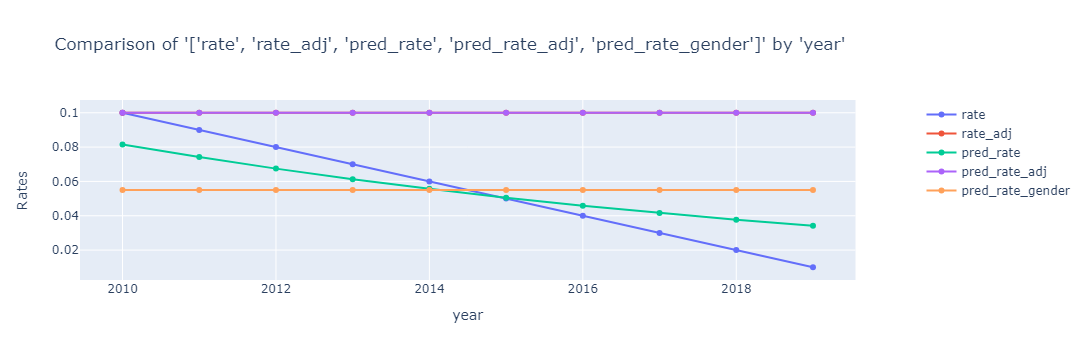

In [22]:
charters.compare_rates(
    model_data[model_data["gender"] == 1],
    x_axis="year",
    rates=["rate", "rate_adj", "pred_rate", "pred_rate_adj", "pred_rate_gender"],
)

## Weighting

This is a simple example compares a GLM when weighting vs. not weighting.
1. **weighting**: this will produce a rate that is close to .9
2. **non-weighted**: this will produce a rate that is the average regardless of weight

In [23]:
model_data = pd.read_csv("tests/files/forecast/simple_data_extreme.csv")

In [24]:
model_data

,record,expose,rate,actual
0,1,1000000,0.9,900000.0
1,1,1,0.1,0.1


In [25]:
X = model_data["record"]
y = model_data["rate"]
success = model_data["actual"]
failure = model_data["expose"] - model_data["actual"]
weights = model_data["expose"]

In [26]:
GLM = models.GLM()
GLM.fit(X, y, weights)
predictions = GLM.model.predict(X)
predictions

 2024-04-19 00:59:57 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002437F6795B0> family... 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | fit the model 


0    0.899999
1    0.899999
dtype: float64

In [27]:
GLM = models.GLM()
GLM.fit(X, y)
predictions = GLM.model.predict(X)
predictions

 2024-04-19 00:59:57 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000002437CF7E460> family... 
 2024-04-19 00:59:57 | morai.forecast.models | INFO     | fit the model 


0    0.5
1    0.5
dtype: float64

In [28]:
GLM = models.GLM()
GLM.fit(X, pd.concat([success, failure], axis=1))
predictions = GLM.model.predict(X)
predictions

 2024-04-19 00:59:58 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 00:59:58 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x0000024300032E50> family... 
 2024-04-19 00:59:58 | morai.forecast.models | INFO     | fit the model 


0    0.899999
1    0.899999
dtype: float64

## Credibility

### Importance

A basis of Buhlmann credibility is:
   - large number of observations -> increased credibility
   - mean of the hypothetical variances is small (EPV) -> increased credibility
   - variances of the mean are large (VHM) -> increased credibility

The formula is: $$\frac{N}{N + \left(\frac{\text{EPV}}{\text{VHM}}\right)}$$

Taking this in context of a logistic regression that differs by many features the credibility should be influenced by some features. Here are a few comments on those influences:

   - The most important features will have the largest influence on the rate. For example, for a mortality rate, attained age will have a larger influence than sex.



In [69]:
import importlib

importlib.reload(models)

<module 'morai.forecast.models' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\forecast\\models.py'>

In [3]:
blend = pd.read_csv("tests/files/experience/blend_credibility.csv")

In [4]:
preprocess_dict = preprocessors.preprocess_data(
    blend,
    feature_dict={
        "target": ["rate"],
        "weight": ["exposure"],
        "passthrough": ["age", "sex", "risk", "sub", "rare"],
    },
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]

 2024-06-30 16:23:07 | morai.forecast.preprocessors | INFO     | model target: ['rate'] 
 2024-06-30 16:23:07 | morai.forecast.preprocessors | INFO     | model weights: ['exposure'] 
 2024-06-30 16:23:07 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-06-30 16:23:07 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['sub', 'age', 'sex', 'rare', 'risk', 'constant'] 


In [6]:
GLM = models.GLM()
GLM.get_feature_contributions(X, y, weights=weights, base_features=["age"])

 2024-06-30 16:23:29 | morai.forecast.models | INFO     | generating feature contributions from model for 4 features by fitting the model and seeing the reduction in deviance. 
 2024-06-30 16:23:29 | morai.forecast.models | INFO     | base features: '['age', 'constant']' 


,features,contribution,deviance
0,all,1.000000,55.056802
1,base,0.000000,206.645490
2,rare,0.131959,75.060252
3,risk,0.411024,117.363459
4,sex,0.009708,56.528463
5,sub,0.411024,117.363459


In [7]:
GLM.get_odds()

 2024-06-30 16:23:31 | morai.forecast.models | INFO     | generating odds ratio from model 


rare        0.000404
risk        0.794471
sex         0.795323
sub         0.794471
age         1.036657
constant    0.002209
dtype: float64

### SHAP

In [76]:
import shap

shap.initjs()

In [80]:
explainer = shap.Explainer(GLM.model.predict, X)

C:\Users\johnk\miniconda3\envs\morai\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


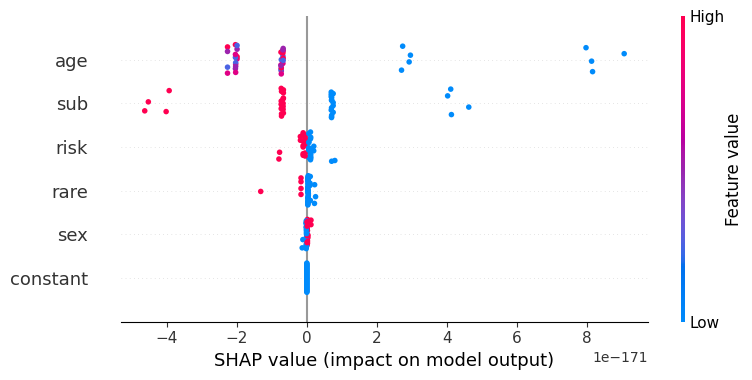

In [81]:
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

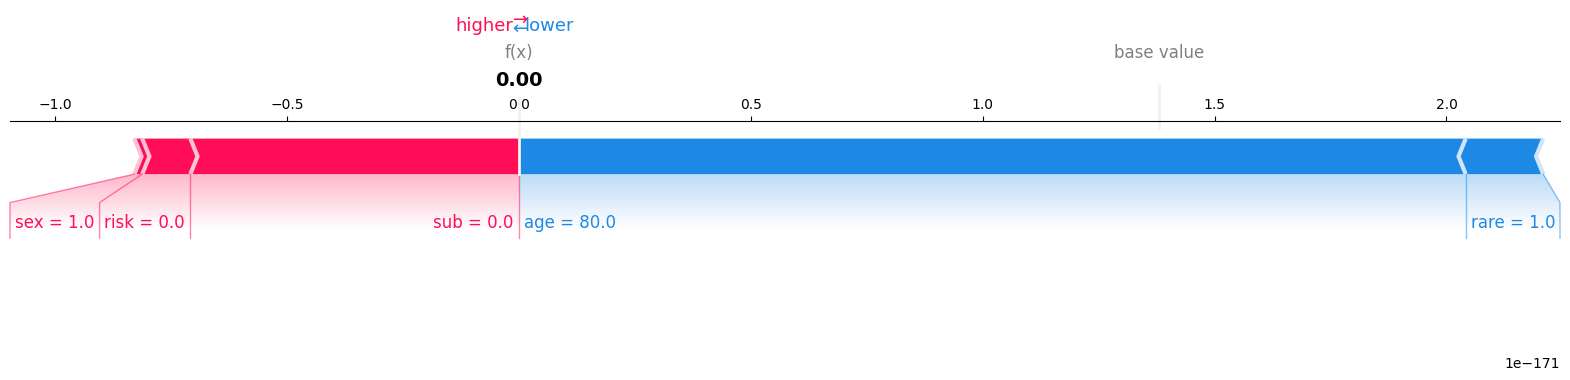

In [115]:
expected_value = np.mean(GLM.model.predict(X))
idx = 8
shap.force_plot(expected_value, shap_values.values[idx], X.iloc[idx], matplotlib=True)

### Grouping

In [10]:
pl_parquet_path = r"files/dataset/mortality_grouped.parquet"

In [11]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
)

In [12]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count:,} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]:,}"
)

row count: 1,793,414 
exposures: 9,873,088,957,759.992


In [13]:
grouped_df = lzdf.collect()

In [14]:
grouped_df = grouped_df.to_pandas()

In [15]:
def get_importance(features, values):
    importance = pd.DataFrame({"feature": features, "importance": values})
    importance = importance.sort_values(by="importance", ascending=False)
    return importance

In [16]:
deviance_dict = {}

In [17]:
grouped_df["binned_attained_age"] = preprocessors.bin_feature(
    grouped_df["attained_age"], 22
)
grouped_df["binned_attained_age"] = grouped_df["binned_attained_age"].astype("category")

In [18]:
feature_dict = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "duration"],
    "ordinal": [
        "smoker_status",
        "binned_attained_age",
    ],
    "ohe": [],
    "nominal": [],
}

In [19]:
preprocess_dict = preprocessors.preprocess_data(
    grouped_df,
    feature_dict=feature_dict,
    standardize=False,
    add_constant=True,
)

 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['attained_age', 'duration', 'constant'] 
 2024-06-30 16:24:13 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['binned_attained_age', 'smoker_status'] 


In [20]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

In [21]:
GLM = models.GLM()
# GLM.fit(X=X, y=y, r_style=False)

In [22]:
# deviance_dict.update({"binned_age": GLM.model.deviance})

In [23]:
# deviance_dict

In [38]:
GLM.get_feature_contributions(X, y, base_features=[])

 2024-06-30 16:41:55 | morai.forecast.models | INFO     | generating feature contributions from model for 4 features by fitting the model and seeing the reduction in deviance. 
 2024-06-30 16:41:55 | morai.forecast.models | INFO     | base features: '['constant']' 


,features,contribution,deviance
0,all,1.000000,107314.798659
1,base,0.000000,147009.903680
2,attained_age,0.035839,108737.418977
3,binned_attained_age,0.007643,107618.178836
4,duration,0.021797,108180.032182
5,smoker_status,0.028144,108431.977781


In [44]:
GLM.fit(X=X[["constant", "duration", "smoker_status", "binned_attained_age"]], y=y, r_style=False)

 2024-06-30 16:45:36 | morai.forecast.models | INFO     | fiting the model 
 2024-06-30 16:45:36 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x0000022F47903AC0> family... 


In [45]:
GLM.model.deviance

108737.41897704714

In [41]:
aa = GLM.model.deviance

In [30]:
baa = GLM.model.deviance

In [31]:
aa

107618.17883648758

In [32]:
baa

108737.41897704717

In [35]:
aa

108738.71921242026